In [3]:
#import libraries
import warnings 
warnings.filterwarnings("ignore",category=FutureWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
import scipy.io as spio
import scipy.signal
import scipy.ndimage
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from collections import namedtuple
import math 
import re 
import pandas as pd
import os
import glob
from os.path import expanduser
import datetime
import statistics as stats
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)


In [4]:
def color_negative_red(val):
    color = 'red' if val > 110 else 'black'
    return 'color: %s' % color


In [5]:
class Keypoint:
    tag = ""
    parent = ['']
    child = ['']
    point = None

    def __init__(self,tag=None,parent=None,child=None,point=None):
        if tag is not None:            
            self.tag = tag
        if parent is not None:
            self.parent = parent
        if child is not None:
            self.child = child
        if point is not None:
            self.point = point


In [6]:
class Skeleton:
    keypoints = [Keypoint() for i in range(17)]
    tag2id = {
        "shoulderCenter" : 0,
        "head" : 1,
        "shoulderLeft" : 2,
        "elbowLeft" : 3,
        "handLeft" : 4,
        "shoulderRight" : 5,
        "elbowRight" : 6,
        "handRight" : 7,
        "hipCenter" : 8,
        "hipLeft" : 9,
        "kneeLeft" : 10,
        "ankleLeft" : 11,
        "footLeft" : 12,
        "hipRight" : 13,
        "kneeRight" : 14,
        "ankleRight" : 15,
        "footRight" : 16,
    }
    keypoints[tag2id["shoulderCenter"]] = Keypoint("shoulderCenter",[''],['head','shoulderLeft','shoulderRight','hipCenter'])
    keypoints[tag2id["head"]] = Keypoint("head",['shoulderCenter'],[''])
    keypoints[tag2id["shoulderLeft"]] = Keypoint("shoulderLeft",['shoulderCenter'],['elbowLeft'])
    keypoints[tag2id["elbowLeft"]] = Keypoint("elbowLeft",['shoulderLeft'],['handLeft'])
    keypoints[tag2id["handLeft"]] = Keypoint("handLeft",['elbowLeft'],[''])
    keypoints[tag2id["shoulderRight"]] = Keypoint("shoulderRight",['shoulderCenter'],['elbowRight'])
    keypoints[tag2id["elbowRight"]] = Keypoint("elbowRight",['shoulderRight'],['handRight'])
    keypoints[tag2id["handRight"]] = Keypoint("handRight",['elbowRight'],[''])
    keypoints[tag2id["hipCenter"]] = Keypoint("hipCenter",['shoulderCenter'],['hipLeft','hipRight'])
    keypoints[tag2id["hipLeft"]] = Keypoint("hipLeft",['shoulderCenter'],['kneeLeft'])
    keypoints[tag2id["kneeLeft"]] = Keypoint("kneeLeft",['hipLeft'],['ankleLeft'])
    keypoints[tag2id["ankleLeft"]] = Keypoint("ankleLeft",['kneeLeft'],['footLeft'])
    keypoints[tag2id["footLeft"]] = Keypoint("footLeft",['ankleLeft'],[''])
    keypoints[tag2id["hipRight"]] = Keypoint("hipRight",['shoulderCenter'],['kneeRight'])
    keypoints[tag2id["kneeRight"]] = Keypoint("kneeRight",['hipRight'],['ankleRight'])
    keypoints[tag2id["ankleRight"]] = Keypoint("ankleRight",['kneeRight'],['footRight'])
    keypoints[tag2id["footRight"]] = Keypoint("footRight",['ankleRight'],[''])

    def __init__(self,keyp_map=None):
        if keyp_map is not None:
            for tag in keyp_map.keys():
                self.keypoints[self.tag2id[tag]].point = keyp_map[tag] 

    def getKeypoint(self,keyp_tag):
        return self.keypoints[self.tag2id[keyp_tag]].point

    def getChild(self,keyp_tag):
        return self.keypoints[self.tag2id[keyp_tag]].child

    def getParent(self,keyp_tag):
        return self.keypoints[self.tag2id[keyp_tag]].parent

    def getTransformation(self):
        sagittal = None
        coronal = None
        transverse = None
        T = np.eye(4,4)
        if self.getKeypoint("shoulderLeft") is not None:
            if self.getKeypoint("shoulderRight") is not None:
                sagittal = self.getKeypoint("shoulderLeft")[0]-self.getKeypoint("shoulderRight")[0]
                sagittal = sagittal/np.linalg.norm(sagittal)
        if self.getKeypoint("shoulderCenter") is not None:
            if self.getKeypoint("hipLeft") is not None:
                if self.getKeypoint("hipRight") is not None:
                    transverse = self.getKeypoint("shoulderCenter")[0]-0.5*(self.getKeypoint("hipLeft")[0]+self.getKeypoint("hipRight")[0])
                    transverse = transverse/np.linalg.norm(transverse)
        if self.getKeypoint("shoulderCenter") is not None:
            pSC = self.getKeypoint("shoulderCenter")[0]

        if sagittal is not None:
            if coronal is not None:
                coronal = np.cross(sagittal,transverse)
                T[0,0]=coronal[0]
                T[1,0]=coronal[1]
                T[2,0]=coronal[2]
                T[0,1]=sagittal[0]
                T[1,1]=sagittal[1]
                T[2,1]=sagittal[2]
                T[0,2]=transverse[0]
                T[1,2]=transverse[1]
                T[2,2]=transverse[2]
                T[0,3]=pSC[0]
                T[1,3]=pSC[1]
                T[2,3]=pSC[2]
                T[3,3]=1
        return T

    def show(self):
        for i in range(len(self.keypoints)):
            k = self.keypoints[i]
            print("keypoint[", k.tag, "]", "=", k.point)


In [7]:
class Exercise:
    name = ""
    typee = ""
    metrics = []

class Tug(Exercise):
    name = "tug"
    typee = "test"
    metrics = ["ROM_0","ROM_1","ROM_2","ROM_3","ROM_4","ROM_5","step_0"]
    result = []
    month_res = {
        0: [],
        1: [],
        2: [],
        3: [],
        4: [],
        5: [],
        6: [],
        7: [],
        8: [],
        9: [],
        10: [],
        11: []
    }

    def __init__(self,month,result):
        self.result = result
        self.month_res[month] = result

    def getResult(self,month):
        return self.month_res[month]



In [8]:
class Metric:
    name = ''

    def __init__(self,name):
        self.name = name


class Step(Metric):
    name = "step"
    en_projection = False
    medfilt = 1
    step_thresh = 0.0
    tstart = 0.0
    tend = 0.0
    step_length = []
    step_width = []
    step_distance = []
    filtered_step_distance = []
    strikes = []
    nsteps = 0
    cadence = 0.0
    speed = 0.0
    ex_time = 0.0
    
    def __init__(self,medfilt_window,en_projection,tstart,tend,step_thresh):

        # scipy median filter requires odd kernel size
        self.medfilt = int(medfilt_window)
        if not (self.medfilt & 1):
            self.medfilt = self.medfilt + 1

        self.tstart = tstart
        self.tend = tend
        self.step_thresh = step_thresh
        self.en_projection = en_projection

    def compute(self,skeleton):
        alj = skeleton.getKeypoint("ankleLeft")
        arj = skeleton.getKeypoint("ankleRight")
        ankles_diff = alj[:, :2] - arj[:, :2]

        if self.en_projection:
            if skeleton.getKeypoint("shoulderLeft") is not None and skeleton.getKeypoint("shoulderRight") is not None:
                sagittal = skeleton.getKeypoint("shoulderLeft")[0] - skeleton.getKeypoint("shoulderRight")[0]
                sagittal = sagittal / np.linalg.norm(sagittal)
            for i in range(len(alj)):
                v = alj[i,:] - arj[i,:]
                dist = np.dot(v,np.transpose(sagittal))
                v = v - dist * sagittal
                self.step_distance.append(np.linalg.norm(v))
                self.filtered_step_distance = scipy.signal.medfilt(self.step_distance,kernel_size=self.medfilt)
        else:
            # ankles_diff_filtered = scipy.ndimage.median_filter(ankles_diff, size = (self.medfilt, self.medfilt))
            ankles_diff_filtered = scipy.signal.savgol_filter(ankles_diff, 20, 2, axis=0)
            self.filtered_step_distance = np.linalg.norm(ankles_diff_filtered, axis=1)
            self.step_distance = np.linalg.norm(ankles_diff, axis=1)

            outliers_indices = np.where(np.abs(scipy.stats.zscore(self.filtered_step_distance)) > 3)[0]
            self.filtered_step_distance[outliers_indices] = 0.0

        #self.strikes = scipy.signal.find_peaks_cwt(self.filtered_step_distance, np.arange(1, 42), min_snr=1)
        self.strikes,_ = scipy.signal.find_peaks(self.filtered_step_distance, height = self.step_thresh, distance = 10)
        slen = self.filtered_step_distance[self.strikes]
        self.step_length = stats.mean(slen)
        self.step_width = np.fabs(ankles_diff)
        self.nsteps = len(self.strikes)
        self.cadence = self.nsteps / (self.tend - self.tstart)
        self.speed = self.step_length * self.cadence
        self.ex_time = self.tend - self.tstart


In [9]:
class Metric:
    name = ''

    def __init__(self,name):
        self.name = name


class Step(Metric):
    name = "step"
    en_projection = False
    medfilt = 1
    step_thresh = 0.0
    tstart = 0.0
    tstanding = 0.0
    tforward = 0.0
    tturning = 0.0
    tbackward = 0.0
    tsitting = 0.0
    tend = 0.0
    step_length = []
    step_width = []
    step_distance = []
    filtered_step_distance = []
    strikes = []
    nsteps = 0
    cadence = 0.0
    speed = 0.0
    ex_time = 0.0
    
    def __init__(self,medfilt_window,en_projection,step_thresh):

        # scipy median filter requires odd kernel size
        self.medfilt = int(medfilt_window)
        if not (self.medfilt & 1):
            self.medfilt = self.medfilt + 1

        self.step_thresh = step_thresh
        self.en_projection = en_projection

    def compute_timing(self, skeleton):
        sc = skeleton.getKeypoint("shouldCenter")
        hc = skeleton.getKeypoint("hipCenter")
        alj = skeleton.getKeypoint("ankleLeft")
        arj = skeleton.getKeypoint("ankleRight")

        vel_hipCenter_x = scipy.signal.savgol_filter(hc, 20, 2, 1, axis=1)
        vel_hipCenter_z = scipy.signal.savgol_filter(hc, 20, 2, 1, axis=2)
        vel_ankleLeft_x = scipy.signal.savgol_filter(alj, 20, 2, 1, axis=1)
        vel_ankleLeft_z = scipy.signal.savgol_filter(alj, 20, 2, 1, axis=2)
        vel_ankleRight_x = scipy.signal.savgol_filter(arj, 20, 2, 1, axis=1)
        vel_ankleRight_z = scipy.signal.savgol_filter(arj, 20, 2, 1, axis=2)

    def compute(self,skeleton):
        alj = skeleton.getKeypoint("ankleLeft")
        arj = skeleton.getKeypoint("ankleRight")
        ankles_diff = alj[:, :2] - arj[:, :2]

        if self.en_projection:
            if skeleton.getKeypoint("shoulderLeft") is not None and skeleton.getKeypoint("shoulderRight") is not None:
                sagittal = skeleton.getKeypoint("shoulderLeft")[0] - skeleton.getKeypoint("shoulderRight")[0]
                sagittal = sagittal / np.linalg.norm(sagittal)
            for i in range(len(alj)):
                v = alj[i,:] - arj[i,:]
                dist = np.dot(v,np.transpose(sagittal))
                v = v - dist * sagittal
                self.step_distance.append(np.linalg.norm(v))
                self.filtered_step_distance = scipy.signal.medfilt(self.step_distance,kernel_size=self.medfilt)
        else:
            # ankles_diff_filtered = scipy.ndimage.median_filter(ankles_diff, size = (self.medfilt, self.medfilt))
            ankles_diff_filtered = scipy.signal.savgol_filter(ankles_diff, 20, 2, axis=0)
            self.filtered_step_distance = np.linalg.norm(ankles_diff_filtered, axis=1)
            self.step_distance = np.linalg.norm(ankles_diff, axis=1)

            outliers_indices = np.where(np.abs(scipy.stats.zscore(self.filtered_step_distance)) > 3)[0]
            self.filtered_step_distance[outliers_indices] = 0.0

        #self.strikes = scipy.signal.find_peaks_cwt(self.filtered_step_distance, np.arange(1, 42), min_snr=1)
        self.strikes,_ = scipy.signal.find_peaks(self.filtered_step_distance, height = self.step_thresh, distance = 10)
        slen = self.filtered_step_distance[self.strikes]
        self.step_length = stats.mean(slen)
        self.step_width = np.fabs(ankles_diff)
        self.nsteps = len(self.strikes)
        self.cadence = self.nsteps / (self.tend - self.tstart)
        self.speed = self.step_length * self.cadence
        self.ex_time = self.tend - self.tstart


In [9]:
def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    data = spio.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

def _check_keys(dict):
    '''
    checks if entries in dictionary are mat-objects. If yes
    todict is called to change them to nested dictionaries
    '''
    for key in dict:
        if isinstance(dict[key],  spio.matlab.mat_struct):
            dict[key] = _todict(dict[key])
    return dict        

def _todict(matobj):
    '''
    A recursive function which constructs from matobjects nested dictionaries
    '''
    dict = {}
    for strg in matobj._fieldnames:
        elem = matobj.__dict__[strg]
        if isinstance(elem, spio.matlab.mat_struct):
            dict[strg] = _todict(elem)
        else:
            dict[strg] = elem
    return dict



## Dati anagrafici 

In [10]:

#load file 
home = expanduser("~")
id_patient = 'datadump-FDG-002-20230208-mr'
pth = home + '/dev_iit/assistive-rehab/data_exp/'+ id_patient
files = glob.glob(os.path.join(pth, '*.mat'))
lastfile = max(files, key=os.path.getctime)

#print personal data
i = [pos for pos, char in enumerate(lastfile) if char == "-"]
i1 = i[-3]
i2 = i[-2]
name = lastfile[i1+1:i2]
surname = ""
age = ""

personaldata = []
personaldata.append(name)
personaldata.append(surname)
personaldata.append(age)        
table = pd.DataFrame(personaldata) 
table.rename(index={0:"Nome",1:"Cognome",2:"Età"},  columns={0:"Paziente"}, inplace=True)
display(table) 

,Paziente
Nome,002
Cognome,
Età,


In [11]:

data = []
ctime = []
filename = []
tagex = []
files.sort(key=os.path.getctime)
for fi in files:
    i = [pos for pos, char in enumerate(fi) if char == "-"]
    i1 = i[-3]
    i2 = i[-2]
    i3 = i[-1]
    namei = fi[i1+1:i2]
    if namei == name:
        filename.append(fi)
        data.append(loadmat(fi)) #data.append(scipy.io.loadmat(fi))
        tagex.append(fi[i2+1:i3])
        ctime.append(os.path.getctime(fi))   

In [12]:
time = []
month = []
exercises = []
ex_names = []
#count how many exercise of the same type were performed at that month
countexmonth = {
    "tug" : [0,0,0,0,0,0,0,0,0,0,0,0]
}

for i in range(len(data)):

    datai = data[i]
    time.append(datai['Time_samples'])
    monthi = datetime.date.fromtimestamp(ctime[i]).month-1
    month.append(monthi)
    shoulderCenter = datai['Keypoints']['shoulderCenter']
    head = datai['Keypoints']['head']
    shoulderLeft = datai['Keypoints']['shoulderLeft']
    shoulderRight = datai['Keypoints']['shoulderRight']
    elbowLeft = datai['Keypoints']['elbowLeft']
    handLeft = datai['Keypoints']['handLeft']
    elbowRight = datai['Keypoints']['elbowRight']
    handRight = datai['Keypoints']['handRight']
    hipLeft = datai['Keypoints']['hipLeft']
    hipRight = datai['Keypoints']['hipRight']
    ankleLeft = datai['Keypoints']['ankleLeft']
    ankleRight = datai['Keypoints']['ankleRight']
    kneeLeft = datai['Keypoints']['kneeLeft']
    kneeRight = datai['Keypoints']['kneeRight']
    footLeft = datai['Keypoints']['footLeft']
    footRight = datai['Keypoints']['footRight']
    hipCenter = datai['Keypoints']['hipCenter']

    key_pam = {
        "shoulderCenter" : shoulderCenter,
        "head" : head,
        "shoulderLeft" : shoulderLeft,
        "shoulderRight" : shoulderRight,
        "elbowLeft" : elbowLeft,
        "handLeft" : handLeft,
        "elbowRight" : elbowRight,
        "handRight" : handRight,
        "hipLeft" : hipLeft,
        "hipRight" : hipRight,
        "ankleLeft" : ankleLeft,
        "ankleRight" : ankleRight,
        "kneeLeft" : kneeLeft,
        "kneeRight" : kneeRight,
        "footLeft" : footLeft,
        "footRight" : footRight,
        "hipCenter" : hipCenter
    }
    s=Skeleton(key_pam)
    #s.show()

    exname = datai["Exercise"]["name"]
    exname = re.sub(r'[^\w]','',exname)
    ex_names.append(exname)
    result_singleexercise = []
    allmet = datai["Exercise"]["metrics"]
    metrics = allmet.keys()
    for metname in metrics:

        if "step" in metname:
            flt = allmet[metname]["median_filter_window"]
            proj = allmet[metname]["enable_plane_projection"]
            proj = False
            tstart = allmet[metname]["tstart"]
            tend = allmet[metname]["tend"]
            step_thresh = allmet[metname]["step_thresh"]
            step = Step(flt,proj,tstart,tend,step_thresh)
            step.compute(s)
            stepmet = [step.step_distance, step.nsteps, step.cadence, step.speed, step.ex_time,
                       step.filtered_step_distance, step.strikes, step.step_width, step.step_length]
            result_singleexercise.append((step,stepmet))


    if exname == "tug":
        ex = Tug(monthi,result_singleexercise)

    countexmonth[exname][monthi] = 1 + countexmonth[exname][monthi]

    exercises.append(ex)   

In [13]:
time[0][0]

276.87239241600037

In [14]:
s.keypoints[0].point

array([[-5.70641829e-01,  2.94318713e-01,  9.82976553e-01],
       [-5.61625400e-01,  2.93720468e-01,  9.69396759e-01],
       [-5.61593561e-01,  2.93583246e-01,  9.78265678e-01],
       [-5.69742587e-01,  2.89779798e-01,  9.56580846e-01],
       [-5.69715011e-01,  2.89661771e-01,  9.65446336e-01],
       [-5.70172904e-01,  2.91976618e-01,  9.79029764e-01],
       [-5.62177366e-01,  2.96500591e-01,  9.66116878e-01],
       [-5.71167562e-01,  2.96947485e-01,  9.78936220e-01],
       [-5.62983011e-01,  3.00606552e-01,  9.90203209e-01],
       [-5.63018987e-01,  3.00761604e-01,  9.81323299e-01],
       [-5.70641829e-01,  2.94318713e-01,  9.82976553e-01],
       [-5.70641829e-01,  2.94318713e-01,  9.82976553e-01],
       [-5.71637281e-01,  2.99293611e-01,  9.82899524e-01],
       [-5.64023592e-01,  3.05851849e-01,  9.91710606e-01],
       [-5.64023592e-01,  3.05851849e-01,  9.91710606e-01],
       [-5.71600517e-01,  2.99136259e-01,  9.91779856e-01],
       [-5.70641829e-01,  2.94318713e-01

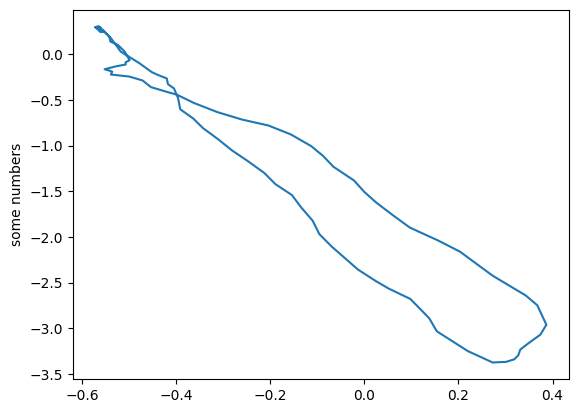

In [15]:
s.keypoints[0].point[:,0]
import matplotlib.pyplot as plt
plt.plot(s.keypoints[0].point[:,0], s.keypoints[0].point[:,1])
plt.ylabel('some numbers')
plt.show()

In [16]:
def compute_timing(skeleton, tag):
        sc = skeleton.getKeypoint(tag)

        win=10
        poly_ord=2
        dev_ord=1

        acc_x = scipy.signal.savgol_filter(sc[:,0], win, poly_ord, 2, delta = time[0][1]-time[0][0], axis=0)
        acc_y = scipy.signal.savgol_filter(sc[:,1], win, poly_ord, 2, delta = time[0][1]-time[0][0], axis=0)
        acc_z = scipy.signal.savgol_filter(sc[:,2], win, poly_ord, 2, delta = time[0][1]-time[0][0], axis=0)
        vel_x = scipy.signal.savgol_filter(sc[:,0], win, poly_ord, dev_ord, delta = time[0][1]-time[0][0], axis=0)
        vel_y = scipy.signal.savgol_filter(sc[:,1], win, poly_ord, dev_ord, delta = time[0][1]-time[0][0], axis=0)
        vel_z = scipy.signal.savgol_filter(sc[:,2], win, poly_ord, dev_ord, delta = time[0][1]-time[0][0], axis=0)        

        return vel_x, vel_y, vel_z, acc_x, acc_y, acc_z

vel_shoulCenter_x, vel_shoulCenter_y, vel_shoulCenter_z, acc_shoulCenter_x, acc_shoulCenter_y, acc_shoulCenter_z= compute_timing(s, "shoulderCenter")
vel_hipCenter_x, vel_hipCenter_y, vel_hipCenter_z, acc_hipCenter_x, acc_hipCenter_y, acc_hipCenter_z = compute_timing(s, "hipCenter")
vel_ankleLeft_x, vel_ankleLeft_y, vel_ankleLeft_z, acc_ankleLeft_x, acc_ankleLeft_y, acc_ankleLeft_z = compute_timing(s, "ankleLeft")
vel_ankleRight_x, vel_ankleRight_y, vel_ankleRight_z, acc_ankleRight_x, acc_ankleRight_y, acc_ankleRight_z = compute_timing(s, "ankleRight")
vel_shoulRight_x, vel_shoulRight_y, vel_shoulRight_z, acc_shoulRight_x, acc_shoulRight_y, acc_shoulRight_z = compute_timing(s, "shoulderRight")
vel_shoulLeft_x, vel_shoulLeft_y, vel_shoulLeft_z, acc_shoulLeft_x, acc_shoulLeft_y, acc_shoulLeft_z = compute_timing(s, "shoulderLeft")

# Fase di alzata

###### L'alzata inizia quando noto un'accelerazione in z del centro delle spalle e, contemporaneamente, una crescita della distanza in y tra il centro delle spalle e il centro delle anche.

In [18]:
dur= 29 #49
nsigma=3
# init_mean= np.mean(acc_shoulCenter_z[0:49])
# init_std= np.std(acc_shoulCenter_z[0:49])
# cond1 = np.where(np.abs((acc_shoulCenter_z-init_mean)/init_std) > nsigma)[0]
init_mean= np.mean(acc_hipCenter_z[0:dur])
init_std= np.std(acc_hipCenter_z[0:dur])
cond1 = np.where(np.abs((acc_hipCenter_z-init_mean)/init_std) > nsigma)[0]

cond2=np.where(np.diff(np.sign(acc_hipCenter_y-acc_shoulCenter_y)))[0]

in_stand_idx= np.intersect1d(cond1,cond2)[0]

#L'alzata finisce quando il centro delle spalle non varia piu' la sua altezza #FDG preferisce quando inizia la camminata
#zero_vel = np.where(np.diff(np.sign(vel_shoulCenter_z[in_stand_idx:])))
#fin_stand_idx = in_stand_idx + zero_vel[0][1]


In [19]:
cond1

array([ 30,  31,  32,  33,  34,  37,  38,  97,  98,  99, 102, 103, 104,
       105, 106])

NameError: name 'in_wf_idx' is not defined

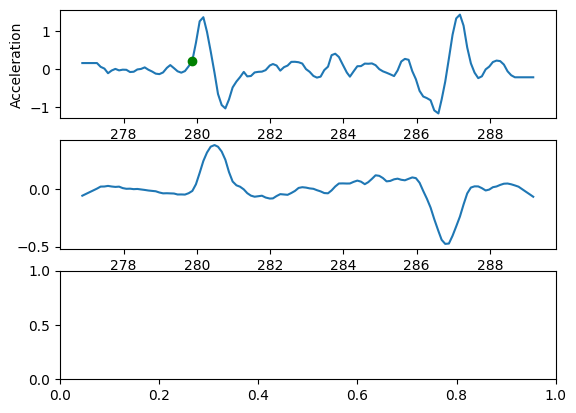

In [20]:
fig, axs = plt.subplots(3)
axs[0].plot(time[0][0:-1], acc_shoulCenter_z)
axs[0].plot(time[0][in_stand_idx],acc_shoulCenter_z[in_stand_idx], 'go')
#axs[0].plot(time[0][0:-1], np.zeros((len(vel_shoulCenter_z),1)))
axs[0].set_ylabel('Acceleration')

axs[1].plot(time[0][0:-1], vel_shoulCenter_z)
#axs[1].plot(time[0][fin_stand_idx],vel_shoulCenter_z[fin_stand_idx], 'ro')
axs[1].plot(time[0][in_wf_idx],vel_shoulCenter_z[in_wf_idx], 'ro')
#axs[1].plot(time[0][0:-1], np.zeros((len(vel_shoulCenter_z),1)))
axs[1].set_ylabel('Velocity')

axs[2].plot(time[0][0:-1], s.keypoints[0].point[:,2])
axs[2].plot(time[0][in_stand_idx],s.keypoints[0].point[in_stand_idx,2], 'go')
#axs[2].plot(time[0][fin_stand_idx],s.keypoints[0].point[fin_stand_idx,2], 'ro')
axs[2].plot(time[0][in_wf_idx],s.keypoints[0].point[in_wf_idx,2], 'ro')
axs[2].set_ylabel('Position')

print('Alzata inizia a:')
print(time[0][in_stand_idx])
print('e finisce a: ') 
#print(time[0][fin_stand_idx])
print(time[0][in_wf_idx])
print('Dura:')
print(time[0][in_wf_idx]-time[0][in_stand_idx])

# Fase di camminata andata

###### La camminata inizia appena uno dei due piedi accelera in y e finisce con l'inizio della rotazione. Quest'ultima inizia quando la distanza in x delle due spalle inizia a descrescere e ho superato la linea dei 3m.

In [21]:
nsigma=3
init_mean= np.mean(acc_ankleRight_y[0:dur])
init_std= np.std(acc_ankleRight_y[0:dur])
in_wf_Right_y_idx = np.where(np.abs((acc_ankleRight_y-init_mean)/init_std) > nsigma)[0]
in_wf_Right_y_idx = np.where(vel_ankleRight_y[in_stand_idx:] < -1)[0]+in_stand_idx-2
init_mean= np.mean(acc_ankleLeft_y[0:dur])
init_std= np.std(acc_ankleLeft_y[0:dur])
in_wf_Left_y_idx = np.where(np.abs((acc_ankleLeft_y-init_mean)/init_std) > nsigma)[0]
in_wf_Left_y_idx = np.where(vel_ankleLeft_y[in_stand_idx:] < -1)[0]+in_stand_idx-2
#in_wf_idx= np.minimum(in_wf_Right_y_idx, in_wf_Left_y_idx)[0]
if in_wf_Right_y_idx[0]<in_wf_Left_y_idx[0]:
    cond1 = in_wf_Right_y_idx
else:
    cond1 = in_wf_Left_y_idx

cond2 = np.array(np.where(vel_hipCenter_y[in_stand_idx:]<0.))[0]+in_stand_idx-2#
in_wf_idx=np.intersect1d(cond1,cond2)[0]

#cond1 = np.array(np.where(acc_shoulRight_x>0))[0]
diff_vel_x=vel_shoulRight_x-vel_shoulLeft_x
diff_acc_x=acc_shoulRight_x-acc_shoulLeft_x
cond1= np.array(np.where(diff_acc_x>0))[0]

rfoot_cross3m = np.array(np.where(s.keypoints[15].point[:,1]<-3.))[0]#
lfoot_cross3m = np.array(np.where(s.keypoints[11].point[:,1]<-3.))[0]#
if rfoot_cross3m[0]<lfoot_cross3m[0]:
    foot_cross3m = rfoot_cross3m
else:
    foot_cross3m = lfoot_cross3m

fin_wf_idx=np.intersect1d(cond1,foot_cross3m)[0]

print('La camminata di andata inizia a:')
print(time[0][in_wf_idx])
print('e finisce a: ') 
print(time[0][fin_wf_idx])
print('Dura:')
print(time[0][fin_wf_idx]-time[0][in_wf_idx])

La camminata di andata inizia a:
280.48265051841736
e finisce a: 
282.77765107154846
Dura:
2.2950005531311035


La camminata di andata inizia a:
280.48265051841736
e finisce a: 
282.77765107154846
Dura:
2.2950005531311035


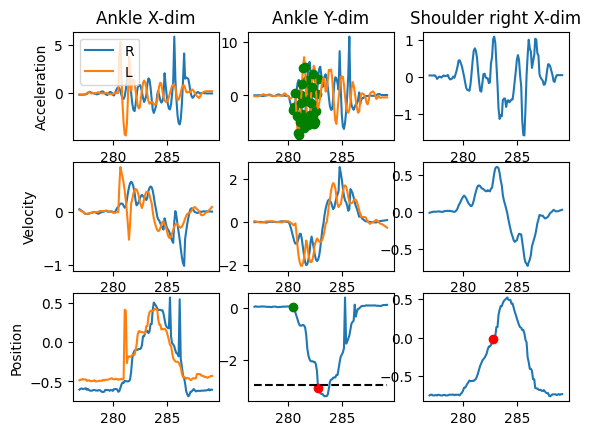

In [22]:
fig, axs = plt.subplots(3,3)
axs[0,0].plot(time[0][0:-1], acc_ankleRight_x, label= 'R')
axs[0,0].plot(time[0][0:-1], acc_ankleLeft_x, label= 'L')
#axs[0,0].plot(time[0][0:-1], np.zeros((len(vel_ankleRight_x),1)))
axs[0,0].set_ylabel('Acceleration')
axs[0,0].set_title('Ankle X-dim')
axs[0,0].legend()

axs[1,0].plot(time[0][0:-1], vel_ankleRight_x)
axs[1,0].plot(time[0][0:-1], vel_ankleLeft_x)
#axs[1,0].plot(time[0][0:-1], np.zeros((len(vel_ankleRight_x),1)))
axs[1,0].set_ylabel('Velocity')

axs[2,0].plot(time[0][0:-1], s.keypoints[15].point[:,0])
axs[2,0].plot(time[0][0:-1], s.keypoints[11].point[:,0])
axs[2,0].set_ylabel('Position')

axs[0,1].plot(time[0][0:-1], acc_ankleRight_y)
axs[0,1].plot(time[0][in_wf_Right_y_idx],acc_ankleRight_y[in_wf_Right_y_idx], 'go')
axs[0,1].plot(time[0][0:-1], acc_ankleLeft_y)
axs[0,1].plot(time[0][in_wf_Left_y_idx],acc_ankleLeft_y[in_wf_Left_y_idx], 'go')
#axs[0,1].plot(time[0][0:-1], np.zeros((len(vel_ankleRight_y),1)))
axs[0,1].set_title('Ankle Y-dim')

axs[1,1].plot(time[0][0:-1], vel_ankleRight_y)
axs[1,1].plot(time[0][0:-1], vel_ankleLeft_y)
#axs[1,1].plot(time[0][0:-1], np.zeros((len(vel_ankleRight_y),1)))

axs[2,1].plot(time[0][0:-1], s.keypoints[15].point[:,1])
axs[2,1].plot(time[0][in_wf_idx],s.keypoints[15].point[in_wf_idx,1], 'go')
axs[2,1].plot(time[0][fin_wf_idx],s.keypoints[15].point[fin_wf_idx,1], 'ro')
#axs[2,1].plot(time[0][0:-1], s.keypoints[11].point[:,1])
#axs[2,1].plot(time[0][in_wf_Left_y_idx],s.keypoints[11].point[in_wf_Left_y_idx,1], 'go')
axs[2,1].plot(time[0][0:-1], -3*np.ones((len(vel_ankleRight_x),1)), 'k--')
#axs[2,1].set_ylim([-0.5, 0.5])

axs[0,2].plot(time[0][0:-1], acc_shoulRight_x)
#axs[0,2].plot(time[0][finish_idx],acc_shoulRight_x[finish_idx], 'go')
#axs[0,2].plot(time[0][0:-1], np.zeros((len(vel_shoulRight_x),1)))
axs[0,2].set_title('Shoulder right X-dim')

axs[1,2].plot(time[0][0:-1], vel_shoulRight_x)
#axs[1,2].plot(time[0][0:-1], np.zeros((len(vel_shoulRight_x),1)))

axs[2,2].plot(time[0][0:-1], s.keypoints[5].point[:,0])
axs[2,2].plot(time[0][fin_wf_idx],s.keypoints[5].point[fin_wf_idx,0], 'ro')
#axs[2,2].plot(time[0][0:-1], -3*np.ones((len(vel_shoulRight_x),1)))

print('La camminata di andata inizia a:')
print(time[0][in_wf_idx])
print('e finisce a: ') 
print(time[0][fin_wf_idx])
print('Dura:')
print(time[0][fin_wf_idx]-time[0][in_wf_idx])

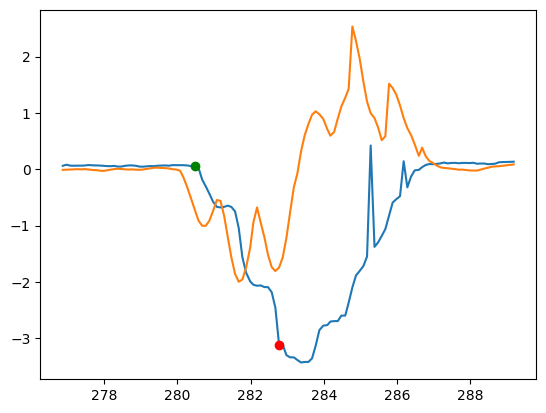

In [23]:
plt.plot(time[0][0:-1], s.keypoints[15].point[:,1])
plt.plot(time[0][in_wf_idx],s.keypoints[15].point[in_wf_idx,1], 'go')
plt.plot(time[0][fin_wf_idx],s.keypoints[15].point[fin_wf_idx,1], 'ro')
plt.plot(time[0][0:-1], vel_ankleRight_y)

# Fase di rotazione

###### La fase di rotazione quando la distanza in x delle due spalle ritorna ai valori iniziali e la velocita' in y del centro spalle e' positiva.

In [24]:
diff_shoul = s.keypoints[5].point[:,0]-s.keypoints[2].point[:,0]
cond1= np.array(np.where(abs(diff_shoul[fin_wf_idx:]-abs(diff_shoul[0]))<0.01))[0]

cond2 = np.array(np.where(vel_shoulCenter_y[fin_wf_idx:]>0.))[0]#

fin_turn1_idx=np.intersect1d(cond1,cond2)[0]+fin_wf_idx

print('La prima rotazione termina a:')
print(time[0][fin_turn1_idx])
print('Dura:')
print(time[0][fin_turn1_idx]-time[0][fin_wf_idx])

La prima rotazione termina a:
284.09495306015015
Dura:
1.3173019886016846


In [25]:
cond1

array([13, 14, 15, 16, 17, 18, 21, 22, 27])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


La camminata di rotazione inizia a:
282.77765107154846
e finisce a: 
284.09495306015015
Dura:
1.3173019886016846


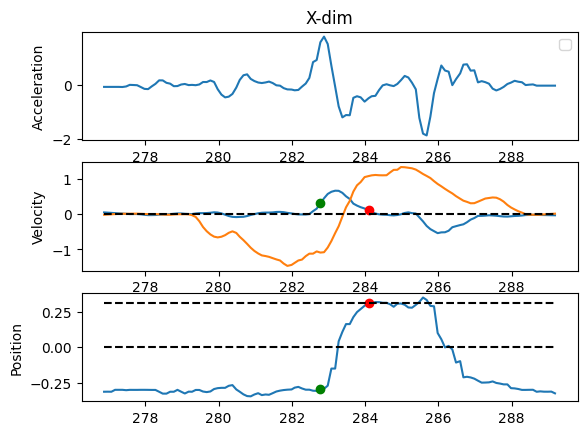

In [26]:
fig, axs = plt.subplots(3)
#axs[0].plot(time[0][0:-1], acc_shoulRight_x, label='R')
#axs[0].plot(time[0][0:-1], acc_shoulLeft_x, label='L')
axs[0].plot(time[0][0:-1], acc_shoulRight_x-acc_shoulLeft_x)
axs[0].set_ylabel('Acceleration')
axs[0].set_title('X-dim')
axs[0].legend()

#axs[1].plot(time[0][0:-1], vel_shoulRight_x)
#axs[1].plot(time[0][0:-1], vel_shoulLeft_x)
diff_vel_x=vel_shoulRight_x-vel_shoulLeft_x
#fin_turn_idx= np.where(np.diff(np.sign(diff_vel_x[fin_wf_idx:])))[0][0]+fin_wf_idx
axs[1].plot(time[0][0:-1], diff_vel_x)
axs[1].plot(time[0][0:-1], vel_shoulCenter_y)
axs[1].plot(time[0][fin_wf_idx],diff_vel_x[fin_wf_idx], 'go')
axs[1].plot(time[0][fin_turn1_idx],diff_vel_x[fin_turn1_idx], 'ro')
axs[1].plot(time[0][0:-1], 0*np.ones((len(vel_shoulRight_x),1)), 'k--')
axs[1].set_ylabel('Velocity')

#axs[2].plot(time[0][0:-1], s.keypoints[5].point[:,0])
#axs[2].plot(time[0][0:-1], s.keypoints[2].point[:,0])
axs[2].plot(time[0][0:-1], s.keypoints[5].point[:,0]-s.keypoints[2].point[:,0])
#axs[2].plot(time[0][0:-1], s.keypoints[0].point[:,1])
axs[2].plot(time[0][fin_wf_idx], diff_shoul[fin_wf_idx], 'go')
axs[2].plot(time[0][fin_turn1_idx], diff_shoul[fin_turn1_idx], 'ro')
axs[2].plot(time[0][0:-1], 0*np.ones((len(vel_shoulRight_x),1)), 'k--')
axs[2].plot(time[0][0:-1], abs(diff_shoul[0])*np.ones((len(vel_shoulRight_x),1)), 'k--')
axs[2].set_ylabel('Position')

print('La camminata di rotazione inizia a:')
print(time[0][fin_wf_idx])
print('e finisce a: ') 
print(time[0][fin_turn1_idx])
print('Dura:')
print(time[0][fin_turn1_idx]-time[0][fin_wf_idx])

# Fase di camminata ritorno

###### La fase di camminata di ritorno termina quando inizia la seconda rotazione.

In [41]:
# pos_ankleRight_x=s.keypoints[15].point[:,0]
# pos_ankleLeft_x=s.keypoints[11].point[:,0]
# fin_wb_idxR = np.where(np.diff(pos_ankleRight_x[fin_turn_idx:])>0.3)[0][0]+fin_turn_idx
# fin_wb_idxL = np.where(np.diff(pos_ankleLeft_x[fin_turn_idx:])>0.3)[0][0]+fin_turn_idx
# #fin_wb_idxR = np.where(np.diff(np.sign(vel_ankleRight_x[fin_turn_idx:])))[0][0]+fin_turn_idx
# #fin_wb_idxL = np.where(np.diff(np.sign(vel_ankleLeft_x[fin_turn_idx:])))[0][0]+fin_turn_idx

diff_acc_x=acc_shoulRight_x-acc_shoulLeft_x
cond1= np.array(np.where(diff_acc_x[fin_turn1_idx:]<0))[0]

rfoot_cross0m = np.array(np.where(s.keypoints[15].point[fin_turn1_idx:,1]>0.))[0]#
lfoot_cross0m = np.array(np.where(s.keypoints[11].point[fin_turn1_idx:,1]>0.))[0]#
if rfoot_cross0m[0]<lfoot_cross0m[0]:
    foot_cross0m = rfoot_cross0m
else:
    foot_cross0m = lfoot_cross0m

fin_wb_idx=np.intersect1d(cond1,foot_cross0m)[0]+fin_turn1_idx
#fin_wb_idx=cond1[0]+fin_turn1_idx

print('La camminata di ritorno inizia a:')
print(time[0][fin_turn1_idx])
print('e finisce a: ') 
print(time[0][fin_wb_idx])
print('Dura:')
print(time[0][fin_wb_idx]-time[0][fin_turn1_idx])

La camminata di ritorno inizia a:
284.09495306015015
e finisce a: 
287.48109245300293
Dura:
3.386139392852783


In [79]:
diff_shoul = abs(s.keypoints[5].point[:,0]-s.keypoints[2].point[:,0])
cond1= np.array(np.where(diff_shoul[fin_turn1_idx:]<diff_shoul[0]-0.1))[0]
print(cond1)
cond2 = np.array(np.where(vel_shoulCenter_y[fin_wf_idx:]>0.))[0]#

fin_wb_idx=cond1[0]+fin_turn1_idx
print(time[0][fin_wb_idx])

[19 20 21 22 23 24 25 26 27 28]
285.97971391677856


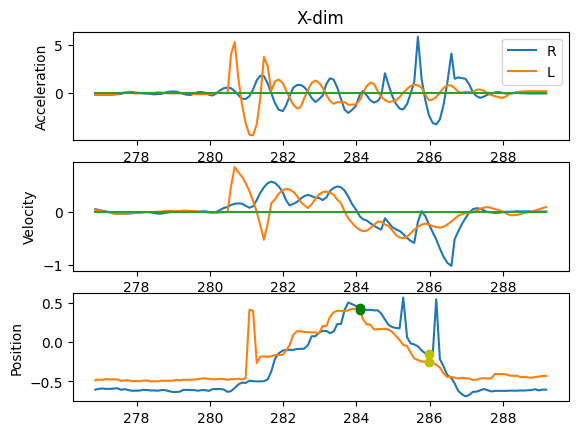

La camminata di ritorno inizia a:
284.09495306015015
e finisce a: 
285.97971391677856
Dura:
1.884760856628418


In [80]:
fig, axs = plt.subplots(3,1)

axs[0].plot(time[0][0:-1], acc_ankleRight_x, label= 'R')
axs[0].plot(time[0][0:-1], acc_ankleLeft_x, label= 'L')
axs[0].plot(time[0][0:-1], np.zeros((len(vel_ankleRight_x),1)))
axs[0].set_ylabel('Acceleration')
axs[0].set_title('X-dim')
axs[0].legend()

axs[1].plot(time[0][0:-1], vel_ankleRight_x)
axs[1].plot(time[0][0:-1], vel_ankleLeft_x)
axs[1].plot(time[0][0:-1], np.zeros((len(vel_ankleRight_x),1)))
axs[1].set_ylabel('Velocity')

axs[2].plot(time[0][0:-1], s.keypoints[15].point[:,0])
axs[2].plot(time[0][fin_turn1_idx],s.keypoints[15].point[fin_turn1_idx,0], 'go')
#axs[2].plot(time[0][fin_wb_idxR],s.keypoints[15].point[fin_wb_idxR,0], 'ro')
axs[2].plot(time[0][fin_wb_idx],s.keypoints[15].point[fin_wb_idx,0], 'yo')
axs[2].plot(time[0][0:-1], s.keypoints[11].point[:,0])
axs[2].plot(time[0][fin_turn1_idx],s.keypoints[11].point[fin_turn1_idx,0], 'go')
#axs[2].plot(time[0][fin_wb_idxL],s.keypoints[11].point[fin_wb_idxL,0], 'ro')
axs[2].plot(time[0][fin_wb_idx],s.keypoints[11].point[fin_wb_idx,0], 'yo')
axs[2].set_ylabel('Position')

#fin_wb_idx=np.minimum(fin_wb_idxR, fin_wb_idxL)
#fin_wb_idx=np.maximum(fin_wb_idxR, fin_wb_idxL)

plt.show()
print('La camminata di ritorno inizia a:')
print(time[0][fin_turn1_idx])
print('e finisce a: ') 
print(time[0][fin_wb_idx])
print('Dura:')
print(time[0][fin_wb_idx]-time[0][fin_turn1_idx])
#print(time[0][np.minimum(fin_wb_idxR, fin_wb_idxL)]-time[0][fin_turn_idx])

# Fase di rotazione 2

###### La seconda rotazione termina quando noto una decelerazione in z del centro delle spalle e, contemporaneamente, una diminuzione della distanza in y tra il centro delle spalle e il centro delle anche.
###### La seconda rotazione termina quando...

In [81]:
nsigma=3
# init_mean= np.mean(acc_shoulCenter_z[0:49])
# init_std= np.std(acc_shoulCenter_z[0:49])
cond1 = np.where(vel_shoulCenter_z[fin_wb_idx:] < 0.)[0]

#cond2=np.where(np.diff(np.sign(acc_hipCenter_y[fin_wb_idx:]-acc_shoulCenter_y[fin_wb_idx:])))[0]
#cond2=np.where(np.diff(np.sign(vel_hipCenter_y[fin_wb_idx:]-vel_shoulCenter_y[fin_wb_idx:])))[0]
cond2=np.where(vel_hipCenter_y[fin_wb_idx:]>vel_shoulCenter_y[fin_wb_idx:])[0]
cond2=np.where(np.sign(vel_hipCenter_y[fin_wb_idx:]-vel_shoulCenter_y[fin_wb_idx:])>0)[0]


fin_turn2_idx= np.intersect1d(cond1,cond2)[0]+fin_wb_idx

fin_turn2_idx = np.where(np.abs(vel_hipCenter_y[fin_wb_idx:]-vel_shoulCenter_y[fin_wb_idx:]-0.05)>0)[0][0]+fin_wb_idx

strikes,_ = scipy.signal.find_peaks(-acc_shoulCenter_z[fin_wb_idx:], height = 0.0, distance = 10)
fin_turn2_idx = strikes[0]+fin_wb_idx

#L'alzata finisce quando il centro delle spalle non varia piu' la sua altezza #FDG preferisce quando inizia la camminata
#zero_vel = np.where(np.diff(np.sign(vel_shoulCenter_z[in_stand_idx:])))
#fin_stand_idx = in_stand_idx + zero_vel[0][1]

# diff_shoul = s.keypoints[5].point[:,0]-s.keypoints[2].point[:,0]
# cond1= np.array(np.where(abs(diff_shoul[fin_wb_idx:]-abs(diff_shoul[0]))<0.1))[0]
# fin_turn2_idx= cond1[0]+fin_wb_idx

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


La camminata di rotazione inizia a:
285.97971391677856
e finisce a: 
286.59415078163147
Dura:
0.6144368648529053


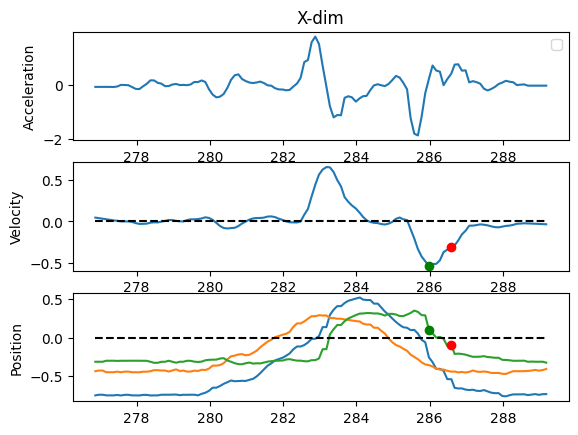

In [82]:
fig, axs = plt.subplots(3)
#axs[0].plot(time[0][0:-1], acc_shoulRight_x, label='R')
#axs[0].plot(time[0][0:-1], acc_shoulLeft_x, label='L')
axs[0].plot(time[0][0:-1], acc_shoulRight_x-acc_shoulLeft_x)
axs[0].set_ylabel('Acceleration')
axs[0].set_title('X-dim')
axs[0].legend()

#axs[1].plot(time[0][0:-1], vel_shoulRight_x)
#axs[1].plot(time[0][0:-1], vel_shoulLeft_x)
diff_vel_x=vel_shoulRight_x-vel_shoulLeft_x
axs[1].plot(time[0][0:-1], diff_vel_x)
#axs[1].plot(time[0][in_turn2_idx],diff_vel_x[in_turn2_idx], 'go')
axs[1].plot(time[0][fin_wb_idx],diff_vel_x[fin_wb_idx], 'go')
axs[1].plot(time[0][fin_turn2_idx],diff_vel_x[fin_turn2_idx], 'ro')
axs[1].plot(time[0][0:-1], 0*np.ones((len(vel_shoulRight_x),1)), 'k--')
axs[1].set_ylabel('Velocity')

axs[2].plot(time[0][0:-1], s.keypoints[5].point[:,0])
axs[2].plot(time[0][0:-1], s.keypoints[2].point[:,0])
diff_shoul = s.keypoints[5].point[:,0]-s.keypoints[2].point[:,0]
axs[2].plot(time[0][0:-1], s.keypoints[5].point[:,0]-s.keypoints[2].point[:,0])
axs[2].plot(time[0][fin_wb_idx], diff_shoul[fin_wb_idx], 'go')
axs[2].plot(time[0][fin_turn2_idx], diff_shoul[fin_turn2_idx], 'ro')
axs[2].plot(time[0][0:-1], 0*np.ones((len(vel_shoulRight_x),1)), 'k--')
axs[2].set_ylabel('Position')

print('La camminata di rotazione inizia a:')
print(time[0][fin_wb_idx])
print('e finisce a: ') 
print(time[0][fin_turn2_idx])
print('Dura:')
print(time[0][fin_turn2_idx]-time[0][fin_wb_idx])



# Fase di discesa

In [83]:
time[0][0:-1].shape

(124,)

Discesa inizia a:
286.59415078163147
e finisce a: 
287.48109245300293
Dura:
0.88694167137146
Tutto il trial dura:
7.605099678039551


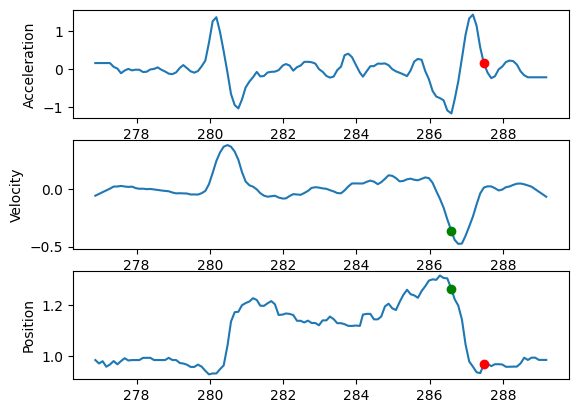

In [84]:
nsigma=3
#zero_vel = np.where(np.diff(np.sign(vel_shoulCenter_z[fin_turn2_idx:])))[0]
#in_sit_idx= fin_turn2_idx + zero_vel[0]

init_mean= np.mean(acc_shoulCenter_z[:dur])
init_std= np.std(acc_shoulCenter_z[:dur])
outliers_indices1 = np.where(np.abs((acc_shoulCenter_z[fin_turn2_idx:]-init_mean)/init_std) < nsigma)[0]
init_mean= np.mean(s.keypoints[0].point[:dur,2])
init_std= np.std(s.keypoints[0].point[:dur,2])
outliers_indices2 = np.where(np.abs((s.keypoints[0].point[fin_turn2_idx:,2]-init_mean)/init_std) < nsigma)[0]
elem=np.intersect1d(outliers_indices1,outliers_indices2)[0]
if (elem==0): 
    fin_sit_idx = len(time[0][0:-1])-1
else:
    fin_sit_idx = fin_turn2_idx + elem

fig, axs = plt.subplots(3)
axs[0].plot(time[0][0:-1], acc_shoulCenter_z)
axs[0].plot(time[0][fin_sit_idx],acc_shoulCenter_z[fin_sit_idx], 'ro')
axs[0].set_ylabel('Acceleration')

axs[1].plot(time[0][0:-1], vel_shoulCenter_z)
axs[1].plot(time[0][fin_turn2_idx],vel_shoulCenter_z[fin_turn2_idx], 'go')
axs[1].set_ylabel('Velocity')

axs[2].plot(time[0][0:-1], s.keypoints[0].point[:,2])
axs[2].plot(time[0][fin_turn2_idx],s.keypoints[0].point[fin_turn2_idx,2], 'go')
axs[2].plot(time[0][fin_sit_idx],s.keypoints[0].point[fin_sit_idx,2], 'ro')
axs[2].set_ylabel('Position')

print('Discesa inizia a:')
print(time[0][fin_turn2_idx])
print('e finisce a: ') 
print(time[0][fin_sit_idx])
print('Dura:')
print(time[0][fin_sit_idx]-time[0][fin_turn2_idx])

print('Tutto il trial dura:')
print(time[0][fin_sit_idx]-time[0][in_stand_idx])

Text(0, 0.5, 'Position')

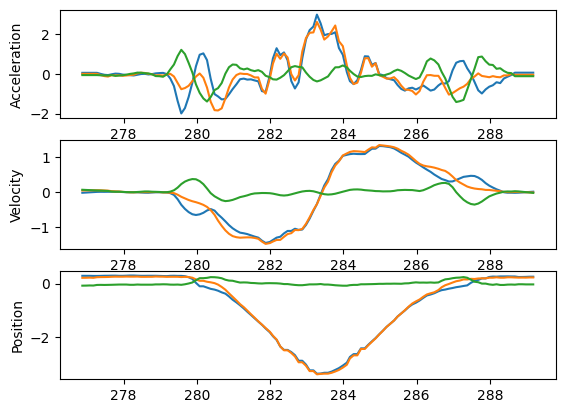

In [36]:
fig, axs = plt.subplots(3)
axs[0].plot(time[0][0:-1], acc_shoulCenter_y)
axs[0].plot(time[0][0:-1], acc_hipCenter_y)
axs[0].plot(time[0][0:-1], acc_hipCenter_y-acc_shoulCenter_y)
axs[0].set_ylabel('Acceleration')

axs[1].plot(time[0][0:-1], vel_shoulCenter_y)
axs[1].plot(time[0][0:-1], vel_hipCenter_y)
axs[1].plot(time[0][0:-1], vel_hipCenter_y-vel_shoulCenter_y)
axs[1].set_ylabel('Velocity')

axs[2].plot(time[0][0:-1], s.keypoints[0].point[:,1])
axs[2].plot(time[0][0:-1], s.keypoints[8].point[:,1])
axs[2].plot(time[0][0:-1], s.keypoints[8].point[:,1]-s.keypoints[0].point[:,1])
axs[2].set_ylabel('Position')


/tmp/ipykernel_19772/2546345123.py:8: UserWarning:

Setting the 'color' property will override the edgecolor or facecolor properties.

/tmp/ipykernel_19772/2546345123.py:19: UserWarning:

Setting the 'color' property will override the edgecolor or facecolor properties.

/tmp/ipykernel_19772/2546345123.py:30: UserWarning:

Setting the 'color' property will override the edgecolor or facecolor properties.

/tmp/ipykernel_19772/2546345123.py:41: UserWarning:

Setting the 'color' property will override the edgecolor or facecolor properties.

/tmp/ipykernel_19772/2546345123.py:52: UserWarning:

Setting the 'color' property will override the edgecolor or facecolor properties.



NameError: name 'fin_sit_idx' is not defined

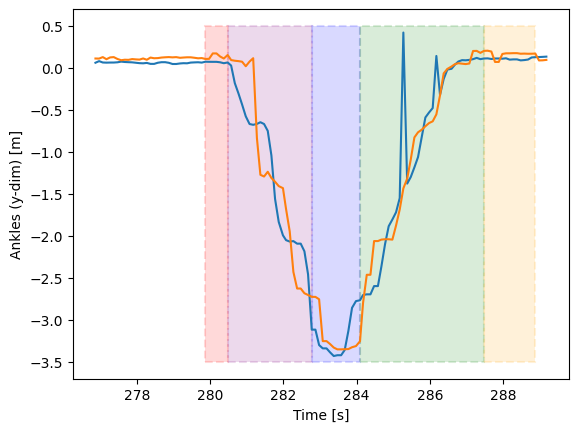

In [37]:
	
import matplotlib.patches as mpatches
plt.plot(time[0][0:-1], s.keypoints[15].point[:,1], label ='R')
plt.plot(time[0][0:-1], s.keypoints[11].point[:,1], label ='L')
plt.xlabel('Time [s]')
plt.ylabel('Ankles (y-dim) [m]')
left, bottom, width, height = (time[0][in_stand_idx], -3.5, time[0][in_wf_idx]-time[0][in_stand_idx], 4)
durata_fase = format(time[0][in_wf_idx]-time[0][in_stand_idx],'.2f')
rect1=mpatches.Rectangle((left,bottom),width,height, 
                        #fill=False,
                        alpha=0.15,
                        color="red",
                       linewidth=1.5,
                       linestyle='--',
                       label =f'Sit2Stand ({durata_fase}")',
                       facecolor="red")
plt.gca().add_patch(rect1)
left, bottom, width, height = (time[0][in_wf_idx], -3.5, time[0][fin_wf_idx]-time[0][in_wf_idx], 4)
durata_fase = format(time[0][fin_wf_idx]-time[0][in_wf_idx],'.2f')
rect2=mpatches.Rectangle((left,bottom),width,height, 
                        #fill=False,
                        alpha=0.15,
                        color="purple",
                       linewidth=1.5,
                       linestyle='--',
                       label =f'Walk forw ({durata_fase}")',
                       facecolor="purple")
plt.gca().add_patch(rect2)
left, bottom, width, height = (time[0][fin_wf_idx], -3.5, time[0][fin_turn1_idx]-time[0][fin_wf_idx], 4)
durata_fase = format(time[0][fin_turn1_idx]-time[0][fin_wf_idx],'.2f')
rect3=mpatches.Rectangle((left,bottom),width,height, 
                        #fill=False,
                        alpha=0.15,
                        color="blue",
                       linewidth=1.5,
                       linestyle='--',
                       label =f'1st turn ({durata_fase}")',
                       facecolor="blue")
plt.gca().add_patch(rect3)
left, bottom, width, height = (time[0][fin_turn1_idx], -3.5, time[0][fin_wb_idx]-time[0][fin_turn1_idx], 4)
durata_fase = format(time[0][fin_wb_idx]-time[0][fin_turn1_idx],'.2f')
rect4=mpatches.Rectangle((left,bottom),width,height, 
                        #fill=False,
                        alpha=0.15,
                        color="green",
                       linewidth=1.5,
                       linestyle='--',
                       label =f'Walk back ({durata_fase}")',
                       facecolor="green")
plt.gca().add_patch(rect4)
left, bottom, width, height = (time[0][fin_wb_idx], -3.5, time[0][fin_turn2_idx]-time[0][fin_wb_idx], 4)
durata_fase= format(time[0][fin_turn2_idx]-time[0][fin_wb_idx],'.2f')
rect5=mpatches.Rectangle((left,bottom),width,height, 
                        #fill=False,
                        alpha=0.15,
                        color="orange",
                       linewidth=1.5,
                       linestyle='--',
                       label =f'2nd turn ({durata_fase}")',
                       facecolor="orange")
plt.gca().add_patch(rect5)
left, bottom, width, height = (time[0][fin_turn2_idx], -3.5, time[0][fin_sit_idx]-time[0][fin_turn2_idx], 4)
durata_fase= format(time[0][fin_sit_idx]-time[0][fin_turn2_idx],'.2f')
rect6=mpatches.Rectangle((left,bottom),width,height, 
                        #fill=False,
                        alpha=0.15,
                        color="#FFEB00",
                       linewidth=1.5,
                       linestyle='--',
                       label =f'Stand2Sit ({durata_fase}")',
                       facecolor="#FFEB00")
plt.gca().add_patch(rect6)
plt.legend()
plt.savefig("/home/carmela/dev_iit/assistive-rehab/EsempioFasiTUG.svg", format="svg")

In [ ]:
dur= 49 #49
nsigma=3

###
init_mean= np.mean(acc_hipCenter_z[0:dur])
init_std= np.std(acc_hipCenter_z[0:dur])
cond1 = np.where(np.abs((acc_hipCenter_z-init_mean)/init_std) > nsigma)[0]

cond2=np.where(np.diff(np.sign(acc_hipCenter_y-acc_shoulCenter_y)))[0]

in_stand_idx= np.intersect1d(cond1,cond2)[0]

###
init_mean= np.mean(acc_ankleRight_y[0:dur])
init_std= np.std(acc_ankleRight_y[0:dur])
in_wf_Right_y_idx = np.where(np.abs((acc_ankleRight_y-init_mean)/init_std) > nsigma)[0]
in_wf_Right_y_idx = np.where(vel_ankleRight_y[in_stand_idx:] < -1)[0]+in_stand_idx-2
init_mean= np.mean(acc_ankleLeft_y[0:dur])
init_std= np.std(acc_ankleLeft_y[0:dur])
in_wf_Left_y_idx = np.where(np.abs((acc_ankleLeft_y-init_mean)/init_std) > nsigma)[0]
in_wf_Left_y_idx = np.where(vel_ankleLeft_y[in_stand_idx:] < -1)[0]+in_stand_idx-2
#in_wf_idx= np.minimum(in_wf_Right_y_idx, in_wf_Left_y_idx)[0]
if in_wf_Right_y_idx[0]<in_wf_Left_y_idx[0]:
    cond1 = in_wf_Right_y_idx
else:
    cond1 = in_wf_Left_y_idx

cond2 = np.array(np.where(vel_hipCenter_y[in_stand_idx:]<0.))[0]+in_stand_idx-2#
in_wf_idx=np.intersect1d(cond1,cond2)[0]

#cond1 = np.array(np.where(acc_shoulRight_x>0))[0]
diff_vel_x=vel_shoulRight_x-vel_shoulLeft_x
diff_acc_x=acc_shoulRight_x-acc_shoulLeft_x
cond1= np.array(np.where(diff_acc_x>0))[0]

rfoot_cross3m = np.array(np.where(s.keypoints[15].point[:,1]<-3.))[0]#
lfoot_cross3m = np.array(np.where(s.keypoints[11].point[:,1]<-3.))[0]#
if rfoot_cross3m[0]<lfoot_cross3m[0]:
    foot_cross3m = rfoot_cross3m
else:
    foot_cross3m = lfoot_cross3m

fin_wf_idx=np.intersect1d(cond1,foot_cross3m)[0]

###
diff_shoul = s.keypoints[5].point[:,0]-s.keypoints[2].point[:,0]
cond1= np.array(np.where(abs(diff_shoul[fin_wf_idx:]-abs(diff_shoul[0]))<0.01))[0]

cond2 = np.array(np.where(vel_shoulCenter_y[fin_wf_idx:]>0.))[0]#

fin_turn1_idx=np.intersect1d(cond1,cond2)[0]+fin_wf_idx

###
diff_acc_x=acc_shoulRight_x-acc_shoulLeft_x
cond1= np.array(np.where(diff_acc_x[fin_turn1_idx:]<0))[0]

rfoot_cross0m = np.array(np.where(s.keypoints[15].point[fin_turn1_idx:,1]>0.))[0]#
lfoot_cross0m = np.array(np.where(s.keypoints[11].point[fin_turn1_idx:,1]>0.))[0]#
if rfoot_cross0m[0]<lfoot_cross3m[0]:
    foot_cross0m = rfoot_cross0m
else:
    foot_cross0m = lfoot_cross0m

fin_wb_idx=np.intersect1d(cond1,foot_cross0m)[0]+fin_turn1_idx

###
cond1 = np.where(vel_shoulCenter_z[fin_wb_idx:] < 0.)[0]

cond2=np.where(np.diff(np.sign(acc_hipCenter_y[fin_wb_idx:]-acc_shoulCenter_y[fin_wb_idx:])))[0]

fin_turn2_idx= np.intersect1d(cond1,cond2)[0]+fin_wb_idx

###
zero_vel = np.where(np.diff(np.sign(vel_shoulCenter_z[fin_turn2_idx:])))[0]
in_sit_idx= fin_turn2_idx + zero_vel[0]

init_mean= np.mean(acc_shoulCenter_z[:dur])
init_std= np.std(acc_shoulCenter_z[:dur])
outliers_indices1 = np.where(np.abs((acc_shoulCenter_z[fin_turn2_idx:]-init_mean)/init_std) < nsigma)[0]
init_mean= np.mean(s.keypoints[0].point[:dur,2])
init_std= np.std(s.keypoints[0].point[:dur,2])
outliers_indices2 = np.where(np.abs((s.keypoints[0].point[fin_turn2_idx:,2]-init_mean)/init_std) < nsigma)[0]
elem=np.intersect1d(outliers_indices1,outliers_indices2)[0]
fin_sit_idx = fin_turn2_idx + elem


 
## Report della seduta odierna
Il paziente ha svolto il seguente esercizio: 

In [48]:

print(exname.encode('ascii')) 

b'tug'


 
on: 

In [49]:

now = datetime.datetime.now()
print(now)

2023-02-28 15:19:24.999164


 
Di seguito si riporta il grafico:

In [50]:
lastsess_time = time[-1]
lastsess_result = exercises[-1].result
lastsess_res_step = []

%matplotlib inline
%matplotlib inline
for i in range(len(lastsess_result)):
    lastsess_met,lastsess_resi = lastsess_result[i]
    lastsess_metname = lastsess_met.name

    ################
    #     STEP     #
    ################
    if lastsess_metname == "step":
        dist=lastsess_resi[5]
        strikes=lastsess_resi[6]
        trace1 = go.Scatter(
            x=lastsess_time,y=dist,
            mode='lines',
            line=dict(
                color='blue',
                width=3
            ),
            name='Distanza tra i piedi'
        )
        trace2 = go.Scatter(
            x=lastsess_time[strikes],y=dist[strikes],
            mode='markers',
            marker=dict(
                color='red',
                size=10
            ),
            name='Appoggio tallone'
        )
        data = [trace1,trace2]
        layout = dict(
            width=750,
            height=600,
            autosize=False,
            title='Distanza tra i piedi',
            font=dict(family='Courier New, monospace', size=22, color='black'),
            xaxis=dict(
                title='time [s]',
                titlefont=dict(
                    family='Courier New, monospace',
                    size=18,
                    color='#7f7f7f'
                )
            ),
            yaxis=dict(
                title='dist [m]',
                titlefont=dict(
                    family='Courier New, monospace',
                    size=18,
                    color='#7f7f7f'
                )
            )
        )
        fig = dict(data=data, layout=layout)
        iplot(fig)

        lastsess_res_step.append(lastsess_resi)
        sla = lastsess_res_step[0][8]
        ns = lastsess_res_step[0][1]
        cad = lastsess_res_step[0][2]
        sp = lastsess_res_step[0][3]
        ex = lastsess_res_step[0][4]
        tablestep = pd.DataFrame([sla, ns, cad, sp, ex])
        tablestep.rename(index={0:"Step Length Avg. [m]",1:"Number of steps",2:"Cadence [steps/s]",
                                3:"Speed [m/s]",4:"Execution time [s]"},
                         columns={0:"Gait analysis"}, inplace=True)
        display(tablestep)



,Gait analysis
Step Length Avg. [m],0.311536
Number of steps,9.000000
Cadence [steps/s],0.535295
Speed [m/s],0.166764
Execution time [s],16.813154


In [51]:
if exname == 'tug':

    table_tug = pd.DataFrame([['Normale mobilità'],['Buona mobilita'],['Ausili cammino'],['Rischio caduta']],
             index=['< 10 s','< 20 s','< 30 s','>= 30 s'],
             columns=['Tabella TUG'])
    display(table_tug)

    time_score = lastsess_res_step[0][4]
    print("Il test è stato svolto in",round(time_score,2),"s")
    if time_score < 10:
        evaluation = 'Normale mobilità'
        print("La valutazione è [1;30;42m",evaluation)
    elif time_score < 20:
        evaluation = 'Buona mobilità, non necessita ausili'
        print("La valutazione è [1;30;42m",evaluation)
    elif time_score < 30:
        evaluation = 'Necessita ausili cammino'
        print("La valutazione è [1;30;43m",evaluation)
    elif time_score >= 30:
        evaluation = 'Rischio caduta'
        print("La valutazione è [1;30;41m",evaluation)


,Tabella TUG
< 10 s,Normale mobilità
< 20 s,Buona mobilita
< 30 s,Ausili cammino
>= 30 s,Rischio caduta


Il test è stato svolto in 16.81 s
La valutazione è  Buona mobilità, non necessita ausili


 
## Andamento stato clinico

 
Gli esercizi svolti dal paziente nei mesi in analisi sono raggruppati come segue:

In [52]:
labels = ["timed-up-and-go"]
values = [tagex.count("tug")]
colors = ['#FEBFB3']

trace = go.Pie(labels=labels, values=values,
               #hoverinfo='label+percent', textinfo='value', 
               textfont=dict(size=20),
               marker=dict(colors=colors, 
                           line=dict(color='#000000', width=2)),
               hoverinfo="label+percent+value",
               hole=0.3
              )
layout = go.Layout(
        title="Performed exercises",
)
data = [trace]
fig = go.Figure(data=data,layout=layout)
iplot(fig)   

 
Di seguito, si riportano gli andamenti delle metriche del paziente, raggruppati per mese: 

In [53]:
keyp2rommax = {
    "shoulderCenter" : [0,0,0,0,0,0,0,0,0,0,0,0],
    "head" : [0,0,0,0,0,0,0,0,0,0,0,0],
    "shoulderLeft" : [0,0,0,0,0,0,0,0,0,0,0,0],
    "elbowLeft" : [0,0,0,0,0,0,0,0,0,0,0,0],
    "handLeft" : [0,0,0,0,0,0,0,0,0,0,0,0],
    "shoulderRight" : [0,0,0,0,0,0,0,0,0,0,0,0],
    "elbowRight" : [0,0,0,0,0,0,0,0,0,0,0,0],
    "handRight" : [0,0,0,0,0,0,0,0,0,0,0,0],
    "hipCenter" : [0,0,0,0,0,0,0,0,0,0,0,0],
    "hipLeft" : [0,0,0,0,0,0,0,0,0,0,0,0],
    "kneeLeft" : [0,0,0,0,0,0,0,0,0,0,0,0],
    "ankleLeft" : [0,0,0,0,0,0,0,0,0,0,0,0],
    "footLeft" : [0,0,0,0,0,0,0,0,0,0,0,0],
    "hipRight" : [0,0,0,0,0,0,0,0,0,0,0,0],
    "kneeRight" : [0,0,0,0,0,0,0,0,0,0,0,0],
    "ankleRight" : [0,0,0,0,0,0,0,0,0,0,0,0],
    "footRight" : [0,0,0,0,0,0,0,0,0,0,0,0]
}
keyp2rommin = {
    "shoulderCenter" : [0,0,0,0,0,0,0,0,0,0,0,0],
    "head" : [0,0,0,0,0,0,0,0,0,0,0,0],
    "shoulderLeft" : [0,0,0,0,0,0,0,0,0,0,0,0],
    "elbowLeft" : [0,0,0,0,0,0,0,0,0,0,0,0],
    "handLeft" : [0,0,0,0,0,0,0,0,0,0,0,0],
    "shoulderRight" : [0,0,0,0,0,0,0,0,0,0,0,0],
    "elbowRight" : [0,0,0,0,0,0,0,0,0,0,0,0],
    "handRight" : [0,0,0,0,0,0,0,0,0,0,0,0],
    "hipCenter" : [0,0,0,0,0,0,0,0,0,0,0,0],
    "hipLeft" : [0,0,0,0,0,0,0,0,0,0,0,0],
    "kneeLeft" : [0,0,0,0,0,0,0,0,0,0,0,0],
    "ankleLeft" : [0,0,0,0,0,0,0,0,0,0,0,0],
    "footLeft" : [0,0,0,0,0,0,0,0,0,0,0,0],
    "hipRight" : [0,0,0,0,0,0,0,0,0,0,0,0],
    "kneeRight" : [0,0,0,0,0,0,0,0,0,0,0,0],
    "ankleRight" : [0,0,0,0,0,0,0,0,0,0,0,0],
    "footRight" : [0,0,0,0,0,0,0,0,0,0,0,0]
}
countrommonth = {
    "shoulderCenter" : [0,0,0,0,0,0,0,0,0,0,0,0],
    "head" : [0,0,0,0,0,0,0,0,0,0,0,0],
    "shoulderLeft" : [0,0,0,0,0,0,0,0,0,0,0,0],
    "elbowLeft" : [0,0,0,0,0,0,0,0,0,0,0,0],
    "handLeft" : [0,0,0,0,0,0,0,0,0,0,0,0],
    "shoulderRight" : [0,0,0,0,0,0,0,0,0,0,0,0],
    "elbowRight" : [0,0,0,0,0,0,0,0,0,0,0,0],
    "handRight" : [0,0,0,0,0,0,0,0,0,0,0,0],
    "hipCenter" : [0,0,0,0,0,0,0,0,0,0,0,0],
    "hipLeft" : [0,0,0,0,0,0,0,0,0,0,0,0],
    "kneeLeft" : [0,0,0,0,0,0,0,0,0,0,0,0],
    "ankleLeft" : [0,0,0,0,0,0,0,0,0,0,0,0],
    "footLeft" : [0,0,0,0,0,0,0,0,0,0,0,0],
    "hipRight" : [0,0,0,0,0,0,0,0,0,0,0,0],
    "kneeRight" : [0,0,0,0,0,0,0,0,0,0,0,0],
    "ankleRight" : [0,0,0,0,0,0,0,0,0,0,0,0],
    "footRight" : [0,0,0,0,0,0,0,0,0,0,0,0]
}
keyp2rommax_avg = {
    "shoulderCenter" : [0,0,0,0,0,0,0,0,0,0,0,0],
    "head" : [0,0,0,0,0,0,0,0,0,0,0,0],
    "shoulderLeft" : [0,0,0,0,0,0,0,0,0,0,0,0],
    "elbowLeft" : [0,0,0,0,0,0,0,0,0,0,0,0],
    "handLeft" : [0,0,0,0,0,0,0,0,0,0,0,0],
    "shoulderRight" : [0,0,0,0,0,0,0,0,0,0,0,0],
    "elbowRight" : [0,0,0,0,0,0,0,0,0,0,0,0],
    "handRight" : [0,0,0,0,0,0,0,0,0,0,0,0],
    "hipCenter" : [0,0,0,0,0,0,0,0,0,0,0,0],
    "hipLeft" : [0,0,0,0,0,0,0,0,0,0,0,0],
    "kneeLeft" : [0,0,0,0,0,0,0,0,0,0,0,0],
    "ankleLeft" : [0,0,0,0,0,0,0,0,0,0,0,0],
    "footLeft" : [0,0,0,0,0,0,0,0,0,0,0,0],
    "hipRight" : [0,0,0,0,0,0,0,0,0,0,0,0],
    "kneeRight" : [0,0,0,0,0,0,0,0,0,0,0,0],
    "ankleRight" : [0,0,0,0,0,0,0,0,0,0,0,0],
    "footRight" : [0,0,0,0,0,0,0,0,0,0,0,0]
}
keyp2rommin_avg = {
    "shoulderCenter" : [0,0,0,0,0,0,0,0,0,0,0,0],
    "head" : [0,0,0,0,0,0,0,0,0,0,0,0],
    "shoulderLeft" : [0,0,0,0,0,0,0,0,0,0,0,0],
    "elbowLeft" : [0,0,0,0,0,0,0,0,0,0,0,0],
    "handLeft" : [0,0,0,0,0,0,0,0,0,0,0,0],
    "shoulderRight" : [0,0,0,0,0,0,0,0,0,0,0,0],
    "elbowRight" : [0,0,0,0,0,0,0,0,0,0,0,0],
    "handRight" : [0,0,0,0,0,0,0,0,0,0,0,0],
    "hipCenter" : [0,0,0,0,0,0,0,0,0,0,0,0],
    "hipLeft" : [0,0,0,0,0,0,0,0,0,0,0,0],
    "kneeLeft" : [0,0,0,0,0,0,0,0,0,0,0,0],
    "ankleLeft" : [0,0,0,0,0,0,0,0,0,0,0,0],
    "footLeft" : [0,0,0,0,0,0,0,0,0,0,0,0],
    "hipRight" : [0,0,0,0,0,0,0,0,0,0,0,0],
    "kneeRight" : [0,0,0,0,0,0,0,0,0,0,0,0],
    "ankleRight" : [0,0,0,0,0,0,0,0,0,0,0,0],
    "footRight" : [0,0,0,0,0,0,0,0,0,0,0,0]
}

stepmonth = {
    "step_length" : [0,0,0,0,0,0,0,0,0,0,0,0],
    "numsteps" : [0,0,0,0,0,0,0,0,0,0,0,0],
    "cadence" : [0,0,0,0,0,0,0,0,0,0,0,0],
    "speed" : [0,0,0,0,0,0,0,0,0,0,0,0],
    "time" : [0,0,0,0,0,0,0,0,0,0,0,0]
}
countstepmonth = [0,0,0,0,0,0,0,0,0,0,0,0]

endpointmonth = {
    "time" : [0,0,0,0,0,0,0,0,0,0,0,0],
    "speed" : [0,0,0,0,0,0,0,0,0,0,0,0]
}
countendpointmonth = [0,0,0,0,0,0,0,0,0,0,0,0]

for i in range(len(exercises)):
    exnamei = exercises[i].name
    for monthi in range(12):
        if countexmonth[exnamei][monthi] != 0:
            res_exi = exercises[i].getResult(monthi)
            for m in range(len(res_exi)): 
                single_metric,result_single_metric = res_exi[m]
                single_metric_name = single_metric.name
                          
                if single_metric_name == "step":
                    stepmonth["step_length"][monthi] = single_metric.step_length + stepmonth["step_length"][monthi]
                    stepmonth["numsteps"][monthi] = single_metric.nsteps + stepmonth["numsteps"][monthi]
                    stepmonth["cadence"][monthi] = single_metric.cadence + stepmonth["cadence"][monthi]
                    stepmonth["speed"][monthi] = single_metric.speed + stepmonth["speed"][monthi]
                    stepmonth["time"][monthi] = single_metric.ex_time + stepmonth["time"][monthi]
                    countstepmonth[monthi] = 1 + countstepmonth[monthi]


In [54]:
counted_exmonth = {
    "tug" : [0,0,0,0,0,0,0,0,0,0,0,0]
}
for i in range(len(exercises)):
    exnamei = exercises[i].name

    for monthi in range(12):  
        if countexmonth[exnamei][monthi] != 0:
            if counted_exmonth[exnamei][monthi] < 1:       
                res_exi = exercises[i].getResult(monthi)
                for m in range(len(res_exi)): 
                    single_metric,result_single_metric = res_exi[m]
                    single_metric_name = single_metric.name

                    if single_metric_name == "step":
                        if countstepmonth[monthi] != 0:
                            stepmonth["step_length"][monthi] = stepmonth["step_length"][monthi]/countstepmonth[monthi]
                            stepmonth["numsteps"][monthi] = stepmonth["numsteps"][monthi]/countstepmonth[monthi]
                            stepmonth["cadence"][monthi] = stepmonth["cadence"][monthi]/countstepmonth[monthi]
                            stepmonth["speed"][monthi] = stepmonth["speed"][monthi]/countstepmonth[monthi]
                            stepmonth["time"][monthi] = stepmonth["time"][monthi]/countstepmonth[monthi]   

                counted_exmonth[exnamei][monthi] = 1

In [55]:
title = "Risultati del Timed Up and Go"
msg1 = HTML('<font size=5><b>'+title+'</b></font>')
msg2 = HTML('<font size=5,font color=gray,font >'+title+'</font>')
if sum(counted_exmonth['tug'])>0:
    display(msg1);
else:
    display(msg2); 

In [56]:
allmonths = [1,2,3,4,5,6,7,8,9,10,11,12]
counted_ex = {
    "tug" : 0
}
for i in range(len(exercises)):
    exnamei = exercises[i].name
    res_exi = exercises[i].result
    if counted_ex[exnamei] < 1:

        #############################
        #      Results for TUG      #
        #############################
        if exnamei == "tug":
            counted_ex[exnamei] = 1
            step_month_table = pd.DataFrame.from_dict(stepmonth,orient='index',
                                                      columns=['Jan','Feb','Mar','Apr','May','Jun',
                                                           'Jul','Aug','Sep','Oct','Nov','Dec'])
            step_month_table.index = ["Numero di passi","Velocità [m/s]","Lunghezza passo [m]",
                                      "Cadenza [steps/s]","Tempo di esecuzione [s]"]
            display(step_month_table)

            for m in range(len(res_exi)): 
                single_metric,result_single_metric = res_exi[m]

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Numero di passi,0,0.311536,0,0,0,0,0,0,0,0,0,0
Velocità [m/s],0,9.000000,0,0,0,0,0,0,0,0,0,0
Lunghezza passo [m],0,0.535295,0,0,0,0,0,0,0,0,0,0
Cadenza [steps/s],0,0.166764,0,0,0,0,0,0,0,0,0,0
Tempo di esecuzione [s],0,16.813154,0,0,0,0,0,0,0,0,0,0
